# [모듈 4.1] Pytorch 를 위한 이미지 전처리
Download | Structure | **Preprocessing (PyTorch)** | Train Model (PyTorch)

### [알림] <font coler="red"> conda_ptroech_p36 커널 </font> 과 함께 사용해야 합니다.

* 이 노트북은 `1.1.download_data` 및 `1.2.structuring_data`로 시작하는 일련의 노트북의 일부입니다. 여기부터는 TensorFlow에 대한 SageMaker의 지원에 중점을 둘 것입니다. 이 시리즈의 다음 노트북은 '4.2.pytorch_training'입니다.


<pre>
</pre>

# 노트북 요약
---

- 이 노트북에서는 PyTorch로 훈련하기 위한 크기 조정 및 데이터 증강 변환을 생성합니다. 
- 또한 SageMaker를 사용한 교육을 위해 데이터 세트를 S3에 업로드합니다.

<pre>
</pre>


# 0. 환경 설정
___
Pytorch를 1.6.0로 업데이트하고 torchvision 을 설치합니다.


### Update the SageMaker Python SDK and PyTorch

In [1]:
import sys
original_pytorch_version = !conda list | grep -E "torch\s" | awk '{print $2}'
!{sys.executable} -m pip install -q "torch==1.6.0" "torchvision" "tqdm"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.


In [2]:
import uuid
import boto3
import torch
import shutil
import pickle
import pathlib
import sagemaker
import numpy as np
from tqdm import tqdm
import torchvision as tv
import matplotlib.pyplot as plt

In [3]:
print(f"pytorch   updated  {original_pytorch_version[0]} -> {torch.__version__}")

pytorch   updated  1.4.0 -> 1.6.0


<pre>
</pre>

# 1. 크기 조정 변환 정의

- 훈련을 위해 GPU로 이동하기 전에 모든 이미지 데이터의 길이, 너비 및 채널 차원이 동일해야 합니다. 
    - 일반적으로 알고리즘은 정사각형 형식을 사용하므로 길이와 너비가 동일하고, 미리 만들어진 많은 데이터 세트에는 이미지가 정사각형으로 잘 잘려져 있습니다.


- 그러나 현업에서는 실제 데이터 세트는 다양한 차원과 비율의 이미지로 존재합니다. 훈련을 위해 데이터 세트를 준비하려면 이미지가 정사각형이 아닌 경우 크기를 조정하고 잘라야 합니다.



- 이미지가 찌그러지거나 늘어나는 것을 방지하려면  <font color="red">이미지를 정사각형으로 *그리고* 이미지의 중요한 개체가 잘리지 않도록 해야 합니다.</font>
    - 불행히도 각 정사각형이 최적인지 확인하는 쉬운 방법은 없으므로 일반적으로 대부분에 잘 작동하는 정사각형을 선택하고 자릅니다.

In [4]:
resize = tv.transforms.Compose(
    [tv.transforms.Resize(224), tv.transforms.CenterCrop(224), tv.transforms.ToTensor()]
)

## 토치비젼을 통한 훈련 데이터 세트 셍성

In [5]:
# 정상 데이터 세트
sample = tv.datasets.ImageFolder(root="data_structured/train", transform=tv.transforms.ToTensor())
# 리사이즈된 데이터 세트
sample_resized = tv.datasets.ImageFolder(root="data_structured/train", transform=resize)

첫번째 레코드의 이미지 Shape 과 레이블 값을 확인 합니다.

In [6]:
example = iter(sample)
image, label = next(example)
print(f"image shape: {image.shape}, label: {label}")


image shape: torch.Size([3, 427, 640]), label: 0


In [7]:
sample = iter(sample)
sample_resized = iter(sample_resized)

다른 이미지에서 크기 조정 변환을 보려면 아래 셀을 다시 실행하십시오.
- 반복해서 실행하시면 다른 이미지의 결과가 보입니다.

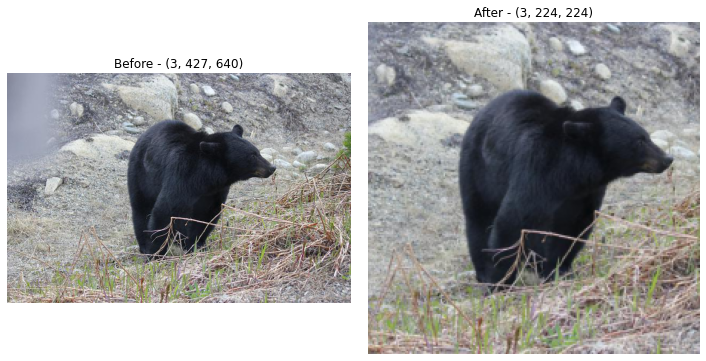

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image = next(iter(sample))[0]
image_resized = next(iter(sample_resized))[0]

ax[0].imshow(image.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title(f"Before - {tuple(image.shape)}")
ax[1].imshow(image_resized.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title(f"After - {tuple(image_resized.shape)}")
plt.tight_layout()

<pre>
</pre>

# 2. 데이터 증강 정의
- 훈련을 개선하는 쉬운 방법은 훈련 알고리즘이 더 잘 일반화되도록 이미지를 무작위로 늘리는 것입니다. 선택할 수 있는 증강은 많지만 증강 기능에 더 많이 추가할수록 훈련을 위해 GPU로 이미지를 보내기 전에 더 많은 처리가 필요하다는 점을 명심하십시오. 
- 또한 이미지에 대한 예측을 있는 그대로 생성하기를 원하기 때문에 검증 데이터를 증강할 필요가 없다는 점에 유의하는 것이 중요합니다.

In [9]:
augment = tv.transforms.Compose(
    [
        # tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(p=0.5),
        tv.transforms.RandomVerticalFlip(p=0.5),
        tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        tv.transforms.ToTensor(),
    ]
)

In [10]:
sample = tv.datasets.ImageFolder(root="data_structured/train", transform=tv.transforms.ToTensor())
sample_augmented = tv.datasets.ImageFolder(root="data_structured/train", transform=augment)

In [11]:
sample = iter(sample)
sample_augmented = iter(sample_augmented)


반복해서 실행하시면 다른 이미지의 결과가 보입니다.

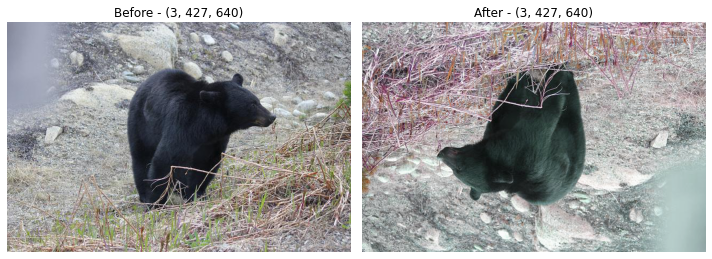

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image = next(iter(sample))[0]
image_augmented = next(iter(sample_augmented))[0]

ax[0].imshow(image.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title(f"Before - {tuple(image.shape)}")
ax[1].imshow(image_augmented.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title(f"After - {tuple(image_augmented.shape)}")
plt.tight_layout()

<pre>
</pre>

# 3. 데이터세트에 변환 (Resize, Augmentation) 적용
- 훈련 데이터 세트에는 크기 조정 및 증대 기능이 적용되지만 검증 데이터 세트는 훈련에 직접 사용되지 않기 때문에 크기만 조정됩니다. 
- 각 레코드에 변환을 적용하기 위해 `.map()` 메서드를 호출할 때. 그러나 실제로는 아직 이미지를 변환하지 않습니다. 대신 훈련을 위해 GPU로 전송되기 직전에 CPU에 의해 변환이 완전히 적용됩니다. 이것은 모든 이미지가 변환될 때까지 기다릴 필요 없이 빠르게 실험할 수 있기 때문에 좋습니다.


- 변환을 무작위로 적용하는 이유가 궁금할 것입니다. 이는 훈련 알고리즘이 에포크의 데이터를 순환하기 때문에 수행됩니다.
    - 매 에포크마다 이미지를 다시 볼 수 있는 기회가 생기므로 매번 동일한 이미지를 전송하는 대신 무작위 증강을 적용합니다. 
    - 이상적으로는 알고리즘이 매 에포크마다 이미지의 모든 버전을 보도록 하겠지만, 이렇게 하면 훈련 데이터 세트의 크기가 증강 수만큼 확장됩니다. 해당 요인에 따라 데이터 스토리지 및 훈련 시간을 확장하는 것은 크게 가치가 없습니다.
    


In [13]:
data_transforms = {
    "train": tv.transforms.Compose(
        [
            tv.transforms.RandomResizedCrop(224),
            tv.transforms.RandomHorizontalFlip(p=0.5),
            tv.transforms.RandomVerticalFlip(p=0.5),
            tv.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            tv.transforms.ToTensor(),
        ]
    ),
    "val": tv.transforms.Compose(
        [tv.transforms.Resize(224), tv.transforms.CenterCrop(224), tv.transforms.ToTensor()]
    ),
}

## PyTorch 데이터 세트 및 데이터 로더 생성

### Datasets
- PyTorch의 데이터 세트는 데이터 세트의 모든 데이터를 추적합니다. 즉, 데이터 세트를 찾을 위치(해당 경로), 해당 데이터가 속한 클래스 및 가져오는 변환을 추적합니다. 
- 이 경우 PyTorch의 편리한 `ImageFolder`를 사용하여 이전 가이드에서 생성한 디렉토리 구조에서 데이터 세트를 쉽게 생성할 것입니다.


In [14]:
data_dir = pathlib.Path("./data_structured")
splits = ["train", "val"]

datasets = {}
for s in splits:
    datasets[s] = tv.datasets.ImageFolder(root=data_dir / s, transform=data_transforms[s])

### 데이터 로더
데이터 로더는 이미지가 훈련을 위해 CPU와 GPU로 전송되는 방식을 구성합니다. 다음과 같은 중요한 하이퍼 매개변수가 포함됩니다.
* **batch_size**: 데이터 로더에게 역전파를 위해 훈련 알고리즘에 한 번에 보낼 이미지 수를 알려줍니다. 따라서 SGD와 같은 최적화 프로그램에 대해 한 에포크에서 발생하는 그래디언트 업데이트 수를 제어합니다.
* **shuffle**: 학습 데이터의 순서를 무작위로 지정합니다.
* **num_workers**: 훈련을 위해 GPU로 보내기 전에 이미지를 로드하고 변환하려는 병렬 프로세스의 수를 정의합니다. 따라서 더 많은 작업자를 추가하면 훈련 속도가 빨라집니다. 그러나 작업자가 너무 많으면 모든 작업자를 관리해야 하는 오버헤드로 인해 훈련 속도가 느려집니다. 또한 각 작업자는 상당한 양의 RAM(batch_size에 따라 다름)을 소비하며 훈련에 사용되는 EC2 인스턴스에서 사용 가능한 CPU 코어보다 많은 작업자를 가질 수 없습니다.

In [15]:
batch_size = 4
shuffle = True
num_workers = 4

dataloaders = {}
for s in splits:
    dataloaders[s] = torch.utils.data.DataLoader(
        datasets[s], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
    )

<a id='idg3c.4'></a>
## 변환 시각화
___
모든 것이 제대로 작동하는지 확인하기 위해 몇 가지 이미지에 변형을 적용하고 확인을 합니다. 새로운 이미지 배치를 보려면 셀을 다시 실행하기만 하면 됩니다.

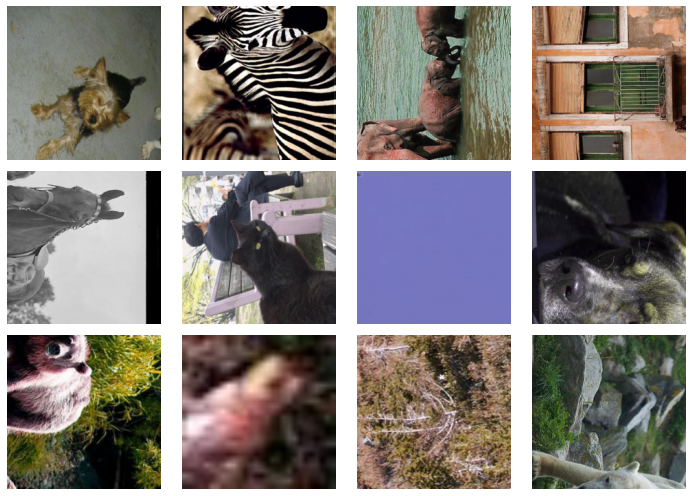

In [16]:
rows = 3
cols = batch_size
fig, axs = plt.subplots(rows, cols, figsize=(10, 7))

for row in range(rows):
    batch = next(iter(dataloaders["train"]))
    images, labels = batch
    for col, image in enumerate(images):
        ax = axs[row, col]
        ax.imshow(image.permute(2, 1, 0))
        ax.axis("off")

plt.tight_layout()

<pre>
</pre>

데이터 세트와 데이터 로더가 정의되었으므로 이제 모델에 대한 훈련 아키텍처를 정의할 준비가 되었습니다.

# 4. S3 에 리사이징된 파일 업로드
___

## 이미지를 리사이징을 하고 디스크에 저장
- data_structured 의 train, val, test 데이터를 리사징하여 data_resized 폴더에 저장

In [17]:
data_dir = pathlib.Path("./data_structured")
splits = ["train", "val", "test"]

datasets = {}
for s in splits:
    datasets[s] = tv.datasets.ImageFolder(
        root=data_dir / s,
        transform=tv.transforms.Compose([tv.transforms.Resize(224), tv.transforms.ToTensor()]),
    )

In [18]:
resized_path = pathlib.Path("./data_resized")
resized_path.mkdir(exist_ok=True)
for s in splits:
    split_path = resized_path / s
    split_path.mkdir(exist_ok=True)
    for idx, (img_tensor, label) in enumerate(tqdm(datasets[s])):
        label_path = split_path / f"{label:02}"
        label_path.mkdir(exist_ok=True)
        filename = datasets[s].imgs[idx][0].split("/")[-1]
        tv.utils.save_image(img_tensor, label_path / filename)

100%|██████████| 275/275 [00:03<00:00, 70.00it/s] 


### 리사이즈된 이미지를 S3에 업로딩
- 약 3분 소요 됩니다.

In [22]:
import sagemaker
bucket_name = sagemaker.Session().default_bucket()
print(bucket_name)

sagemaker-ap-northeast-2-057716757052


In [23]:
pytorch_prefix = 'data_prep_workshop/pytorch'

In [24]:
s3_uploader = sagemaker.s3.S3Uploader()

train_s3_uri = f's3://{bucket_name}/{pytorch_prefix}/data/train'    
data_path = (resized_path / 'train').as_posix()
train_pytorch_s3_uri = s3_uploader.upload(
    local_path=data_path, desired_s3_uri=train_s3_uri
)
print("train_pytorch_s3_uri: \n", train_pytorch_s3_uri)

train_pytorch_s3_uri: 
 s3://sagemaker-ap-northeast-2-057716757052/data_prep_workshop/pytorch/data/train


In [25]:
s3_uploader = sagemaker.s3.S3Uploader()

val_s3_uri = f's3://{bucket_name}/{pytorch_prefix}/data/val'    
data_path = (resized_path / 'val').as_posix()
val_pytorch_s3_uri = s3_uploader.upload(
    local_path=data_path, desired_s3_uri=val_s3_uri
)
print("val_pytorch_s3_uri: \n", val_pytorch_s3_uri)

val_pytorch_s3_uri: 
 s3://sagemaker-ap-northeast-2-057716757052/data_prep_workshop/pytorch/data/val


<pre>
</pre>

## 다음 노트북에서 사용할 변수 저장
- 아래는 다음 노트북에서 변수를 사용하기 위해 저장 합니다.

In [28]:
%store train_pytorch_s3_uri
%store val_pytorch_s3_uri
%store bucket_name

Stored 'train_pytorch_s3_uri' (str)
Stored 'val_pytorch_s3_uri' (str)
Stored 'bucket_name' (str)


## 데이터 확인

In [27]:
! aws s3 ls {train_pytorch_s3_uri} --recursive
! aws s3 ls {val_pytorch_s3_uri} --recursive

2021-12-28 09:58:39      18974 data_prep_workshop/pytorch/data/train/00/000000000502.jpg
2021-12-28 09:58:42      26400 data_prep_workshop/pytorch/data/train/00/000000003481.jpg
2021-12-28 09:58:39      10145 data_prep_workshop/pytorch/data/train/00/000000006437.jpg
2021-12-28 09:58:42      16848 data_prep_workshop/pytorch/data/train/00/000000013843.jpg
2021-12-28 09:58:34      16193 data_prep_workshop/pytorch/data/train/00/000000015391.jpg
2021-12-28 09:58:43      16596 data_prep_workshop/pytorch/data/train/00/000000020136.jpg
2021-12-28 09:58:42      11540 data_prep_workshop/pytorch/data/train/00/000000020247.jpg
2021-12-28 07:37:33      10821 data_prep_workshop/pytorch/data/train/00/000000020972.jpg
2021-12-28 09:58:34       9045 data_prep_workshop/pytorch/data/train/00/000000021963.jpg
2021-12-28 09:58:38      17105 data_prep_workshop/pytorch/data/train/00/000000024351.jpg
2021-12-28 09:58:39      17147 data_prep_workshop/pytorch/data/train/00/000000031375.jpg
2021-12-28 09:58:36  

<pre>
</pre>

## 다음 단계
훈련 및 검증 데이터 세트가 S3에 저장되었으므로 Pytorch 프레임워크용 SageMaker Estimator를 생성하고 원격 EC2 인스턴스에서 훈련 알고리즘을 실행할 수 있습니다.